## Bayesian Modeling
The small size and probabilistic output make this compeition perfect for an invovled, bayesian model. Running locally for optimal access.

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import xarray as xr
import matplotlib.pyplot as plt

RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Read data

In [2]:
df_train = pd.read_csv(r"C:\Users\HG749BX\OneDrive - EY\Documents\Python\age-related-conditions\train.csv")
df_test = pd.read_csv(r"C:\Users\HG749BX\OneDrive - EY\Documents\Python\age-related-conditions\test.csv")
df_greeks = pd.read_csv(r"C:\Users\HG749BX\OneDrive - EY\Documents\Python\age-related-conditions\greeks.csv")

print('No. of records for train : {}'.format(df_train.shape))
print('No. of records for test : {}'.format(df_test.shape))
print('No. of records for greeks : {}'.format(df_greeks.shape))

No. of records for train : (617, 58)
No. of records for test : (5, 57)
No. of records for greeks : (617, 6)


## More Complicated
This attempt will be more complicated as I have to specify distributions for 60ish variables. I need to scale all of this data, and convert some of it into categories. Let's see if we can do that without having to worry about missing values. 

In [217]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

In [4]:
df_full = df_train.merge(df_greeks, how="left")

In [5]:
df_full.shape

(617, 63)

In [6]:
scale_names = [x for x in df_train.columns if x not in ['Id','EJ','Alpha','Beta','Delta','Gamma','Class','Epsilon']]
encode_names = ['EJ','Alpha','Beta','Delta','Gamma']
# need to explicitly drop epsilon, Class

# create pipeline 
full_pipe = Pipeline([
    ('Unite',FeatureUnion([
        ('minmax', ColumnTransformer([
            ('scale', MinMaxScaler(), scale_names)
        ])),
        ('ordin_categ', ColumnTransformer([
            ('encode', OrdinalEncoder(), encode_names)
        ]))
    ]))
])

x = full_pipe.fit_transform(df_full)

In [242]:
# focus on the numerical values for now, try fitting model
target = df_train['Class'].to_numpy()
numer_train = df_train.drop(['Id','EJ','Class'],axis=1)

mms = MinMaxScaler().fit_transform(numer_train)

In [273]:
tiny_data = mms[:,0:13]
x_missing = np.isnan(tiny_data)
X_train = np.ma.masked_array(tiny_data, mask=x_missing)
missing_shape = np.shape(x_missing)
col_shape = np.shape(tiny_data)[1]

In [274]:
tiny_data.shape

(617, 13)

In [275]:
with pm.Model() as walle: 
    # use Mutable Data maybe
    y = pm.MutableData("y", target)
    data = pm.MutableData('data', X_train)
    # impute
    μMask = pm.Normal("μMask", mu=0, sigma=10, shape=(col_shape))
    μ = pm.Normal("μ", mu=μMask, sigma=10)
    ϵ = pm.Normal("ϵ", mu=0, sigma=10)
    # multiply
    θ = pm.Deterministic("θ", pm.math.sigmoid(pm.math.dot(data, μ) + ϵ))
    # θ = pm.Deterministic("θ", pm.math.sigmoid(δ))
    # π = pm.Beta("π", 1., 1.)
    # p = π * 0.5 + ( 1 - π ) * θ
    # response
    response = pm.Bernoulli("response", p = θ, observed=y)

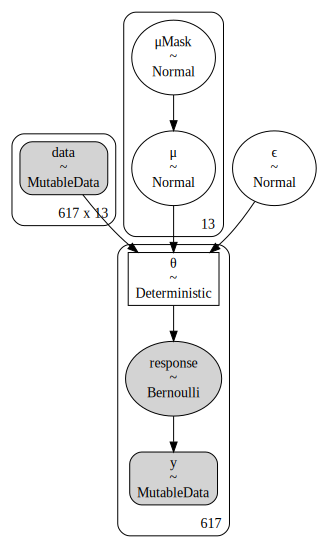

In [276]:
pm.model_to_graphviz(walle)

## Sample the Prior Predictive

In [266]:
# prior predictive
with walle: 
    priorWalleTrace = pm.sample_prior_predictive(samples=100)

In [268]:
az.summary(priorWalleTrace, var_names=["μ", "ϵ"])

arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],-3.001,14.303,-30.300,19.729,1.468,1.041,92.0,112.0,NaN
μ[1],0.945,13.069,-21.503,24.987,1.477,1.048,79.0,77.0,NaN
μ[2],0.385,13.655,-22.429,21.518,1.388,1.008,97.0,117.0,NaN
μ[3],1.591,12.486,-17.360,30.184,1.699,1.208,51.0,93.0,NaN
μ[4],0.411,15.185,-27.471,29.147,1.495,1.060,102.0,112.0,NaN
μ[5],-2.473,14.183,-29.186,23.577,1.797,1.276,65.0,77.0,NaN
μ[6],2.289,12.700,-22.273,22.883,1.263,0.992,100.0,97.0,NaN
μ[7],-0.846,17.500,-32.825,32.855,1.412,1.244,158.0,102.0,NaN
μ[8],0.575,14.374,-26.052,24.482,1.544,1.095,85.0,117.0,NaN
μ[9],3.342,14.099,-22.135,26.445,1.457,1.033,87.0,78.0,NaN


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'μMask'}>,
        <AxesSubplot:title={'center':'μMask'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

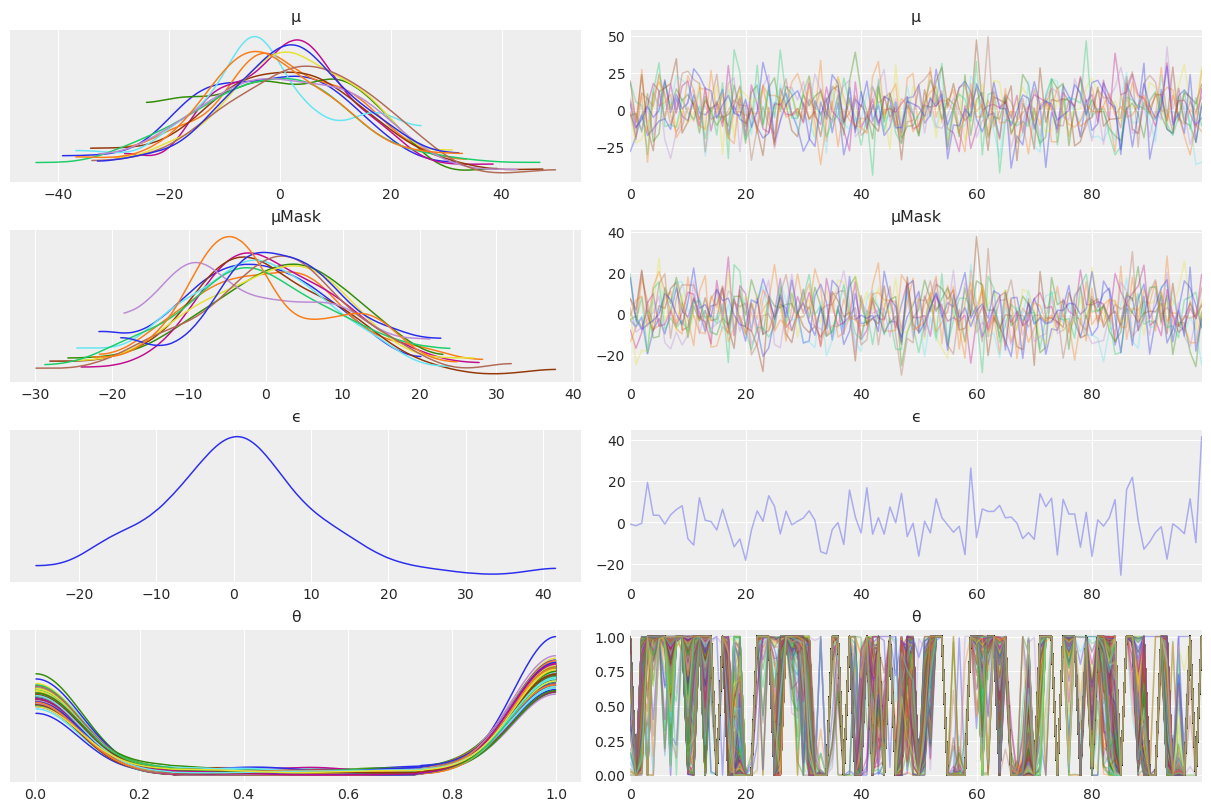

In [269]:
az.plot_trace(priorWalleTrace.prior)

In [ ]:
# slopeVals = priorWalleTrace.prior["μ"].mean(("chain"))
# interceptVals = priorWalleTrace.prior["ϵ"].mean(("chain"))
# xVals = xr.DataArray(np.linspace(-2, 2, 100), dims=["plot_dim"])
# yVals = slopeVals[:,0] * xVals.values + slopeVals[:,1] * xVals.values + slopeVals[:,2] * xVals.values + slopeVals[:,3] * xVals.values + slopeVals[:,4] * xVals.values + interceptVals
# _, ax = plt.subplots()

# ax.plot(xVals, yVals, marker="o", alpha=0.4)

# ax.set_xlabel("Predictor (stdz)")
# ax.set_ylabel("Mean Outcome (stdz)")
# ax.set_title("Prior predictive checks -- Weakly regularizing priors");

## Sample The Posterior

In [277]:
with walle:
    walleTrace = pm.sample(
        draws=1000,
        tune=2000,
        idata_kwargs={"log_likelihood": True},
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'μMask': array([ 0.18634734, -0.39832079,  0.59838295,  0.14633672, -0.45325399,
        0.2908988 ,  0.63499114, -0.3331814 , -0.46628275, -0.17975736,
        0.43076496, -0.21967185, -0.12822274]), 'μ': array([-0.69025473,  0.12485237,  0.79137318,  0.30388312, -0.75122385,
       -0.17729051,  0.39236463,  0.16225162, -0.49251805,  0.31829677,
        1.2677764 , -1.08674542,  0.26211452]), 'ϵ': array(-0.55671262)}

Initial evaluation results:
{'μMask': -41.89, 'μ': -41.9, 'ϵ': -3.22, 'response': -inf}

In [271]:
az.summary(walleTrace, var_names=['μ','ϵ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],6.090,2.431,1.644,10.790,0.036,0.027,4453.0,3025.0,1.0
μ[1],8.463,1.802,5.114,11.852,0.027,0.020,4374.0,2388.0,1.0
μ[2],-4.274,2.922,-10.043,0.932,0.049,0.037,3518.0,2837.0,1.0
μ[3],1.828,1.335,-0.603,4.347,0.019,0.016,5281.0,3056.0,1.0
μ[4],1.983,3.312,-4.647,7.859,0.060,0.050,3091.0,2752.0,1.0
μ[5],-2.903,2.160,-6.855,1.266,0.033,0.027,4392.0,2614.0,1.0
μ[6],6.028,7.117,-6.052,19.658,0.146,0.115,2532.0,2173.0,1.0
μ[7],-1.936,1.038,-3.882,0.024,0.015,0.011,4595.0,3011.0,1.0
μ[8],30.068,11.074,10.265,51.281,0.169,0.126,4351.0,2900.0,1.0
μ[9],-3.065,3.917,-10.501,4.363,0.061,0.054,4190.0,2752.0,1.0


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

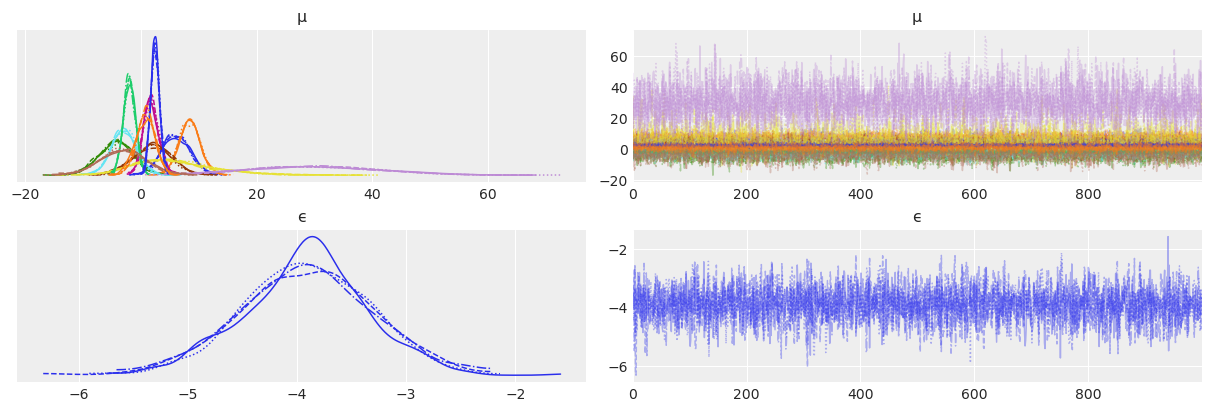

In [272]:
az.plot_trace(walleTrace, var_names=["μ","ϵ"])

## Additional Models - Softmax

In [ ]:
with pm.Model() as walle: 
    # use Mutable Data maybe
    y = pm.MutableData("y", target)
    data = pm.MutableData('data', X_train)
    # impute
    μMask = pm.Normal("μMask", mu=0, sigma=10, shape=(col_shape))
    μ = pm.Normal("μ", mu=μMask, sigma=10)
    ϵ = pm.Normal("ϵ", mu=0, sigma=10)
    # multiply
    θ = pm.Deterministic("θ", pm.math.sigmoid(pm.math.dot(data, μ) + ϵ))
    # θ = pm.Deterministic("θ", pm.math.sigmoid(δ))
    # π = pm.Beta("π", 1., 1.)
    # p = π * 0.5 + ( 1 - π ) * θ
    # response
    response = pm.Bernoulli("response", p = θ, observed=y)

## Additional Models - BART

In [278]:
import pymc_bart as pmb

ModuleNotFoundError: No module named 'pymc_bart'